In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import os
import json
import matplotlib.pyplot as plt


print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Using:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load Data

In [2]:
data = torch.load("./data/training_set.pt", map_location="cpu", weights_only=False)

X_wt = data["wildtype"]
X_mut = data["mutant"]
X_lig = data["ligand"]
Y_flux = data["flux"]
Y_objective = data["objective"]

print(f"Data Shapes: {X_wt[0].shape}, {X_mut[0].shape}, {X_lig[0].shape}, {Y_flux[0]}, {Y_objective[0]}")
print(f"Training Set Size: {len(Y_flux)}")

Data Shapes: (1280,), (1280,), (2048,), 0.2133, 0.8769972144269726
Training Set Size: 7515


# Build Dataset

In [3]:
class FluxDataset(Dataset):
    def __init__(self, X_wt, X_mut, X_lig, y_flux, y_obj):
        self.X_wt = torch.tensor(X_wt, dtype=torch.float32)
        self.X_mut = torch.tensor(X_mut, dtype=torch.float32)
        self.X_diff = self.X_mut - self.X_wt

        self.X_lig = torch.tensor(X_lig, dtype=torch.float32)

        self.y_flux = torch.tensor(y_flux, dtype=torch.float32).unsqueeze(1)
        self.y_obj = torch.tensor(y_obj, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y_flux)

    def __getitem__(self, idx):
        x = torch.cat([self.X_wt[idx], self.X_diff[idx], self.X_lig[idx]], dim=0)
        y = torch.cat([self.y_flux[idx], self.y_obj[idx]], dim=0)
        return x, y

dataset = FluxDataset(X_wt, X_mut, X_lig, Y_flux, Y_objective)

C:\Users\tye\AppData\Local\Temp\ipykernel_21020\4154312285.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  self.X_wt = torch.tensor(X_wt, dtype=torch.float32)


# Define Models

In [4]:
MODELS = [
    {
        "name": "seq2bds-mini",
        "layers": [128, 64],
        "lr": 3e-4
    },
    {
        "name": "seq2bds-small",
        "layers": [256, 128],
        "lr": 1e-4
    },
    {
        "name": "seq2bds-medium",
        "layers": [512, 256, 128],
        "lr": 1e-4
    },
    {
        "name": "seq2bds-large",
        "layers": [1024, 512, 256, 128],
        "lr": 1e-4
    },
    {
        "name": "seq2bds-xlarge",
        "layers": [2048, 1024, 512, 256, 128],
        "lr": 1e-4
    }
]

class ConfigurableMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim, activation=nn.ReLU, dropout=0.1):
        super().__init__()

        layers = []
        prev_dim = input_dim

        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(activation())
            layers.append(nn.Dropout(dropout))
            prev_dim = h

        layers.append(nn.Linear(prev_dim, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

for model in MODELS:
    model["model"] = ConfigurableMLP(dataset[0][0].shape[0], model["layers"], 2).to(device)
    model["train_loss"] = []
    model["val_loss"] = []

# Train Models

In [5]:
def train_model(model, dataset, num_epochs=50, batch_size=512):
    net = model["model"]

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    optimizer = torch.optim.Adam(net.parameters(), lr=model.get("lr", 1e-4))
    loss_fn = nn.MSELoss()
    
    for epoch in range(num_epochs):
        net.train()
        total_train = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            pred = net(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

            total_train += loss.item() * x.size(0)

        avg_train = total_train / train_size

        net.eval()
        total_val = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = net(x)
                loss = loss_fn(pred, y)
                total_val += loss.item() * x.size(0)
        avg_val = total_val / val_size

        model["train_loss"].append(avg_train)
        model["val_loss"].append(avg_val)

        print(f"[{model['name']}] Epoch {epoch+1:03d} | train {avg_train:.4f} | val {avg_val:.4f}")
    
    net.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model["model"](x)
            y_pred.append(pred)
            y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)

    r2 = 1 - (torch.sum((y_true - y_pred) ** 2) / torch.sum((y_true - torch.mean(y_true)) ** 2))
    model["r2"] = r2.item()

    return model

for model in MODELS:
    train_model(model, dataset)

    print(f"[{model['name']}] R2: {model['r2']:.4f}")


[seq2bds-mini] Epoch 001 | train 0.3205 | val 0.1669
[seq2bds-mini] Epoch 002 | train 0.0913 | val 0.0292
[seq2bds-mini] Epoch 003 | train 0.0384 | val 0.0253
[seq2bds-mini] Epoch 004 | train 0.0304 | val 0.0164
[seq2bds-mini] Epoch 005 | train 0.0249 | val 0.0144
[seq2bds-mini] Epoch 006 | train 0.0225 | val 0.0122
[seq2bds-mini] Epoch 007 | train 0.0211 | val 0.0112
[seq2bds-mini] Epoch 008 | train 0.0194 | val 0.0102
[seq2bds-mini] Epoch 009 | train 0.0182 | val 0.0095
[seq2bds-mini] Epoch 010 | train 0.0175 | val 0.0090
[seq2bds-mini] Epoch 011 | train 0.0163 | val 0.0086
[seq2bds-mini] Epoch 012 | train 0.0160 | val 0.0082
[seq2bds-mini] Epoch 013 | train 0.0153 | val 0.0081
[seq2bds-mini] Epoch 014 | train 0.0150 | val 0.0078
[seq2bds-mini] Epoch 015 | train 0.0141 | val 0.0076
[seq2bds-mini] Epoch 016 | train 0.0139 | val 0.0074
[seq2bds-mini] Epoch 017 | train 0.0131 | val 0.0071
[seq2bds-mini] Epoch 018 | train 0.0128 | val 0.0070
[seq2bds-mini] Epoch 019 | train 0.0126 | val 

# Save Models

In [11]:
for model in MODELS:
    os.makedirs(f"./models/{model['name']}", exist_ok=True)

    torch.save(model["model"].state_dict(), f"./models/{model['name']}/dist.pt")
    with open(f"./models/{model['name']}/metadata.json", "w") as f:
        json.dump({
            "name": model["name"],
            "layers": model["layers"],
            "lr": model["lr"],
            "r2": model["r2"],
            "train_loss": model["train_loss"],
            "val_loss": model["val_loss"]
        }, f)
    

# Plot Distributed Models

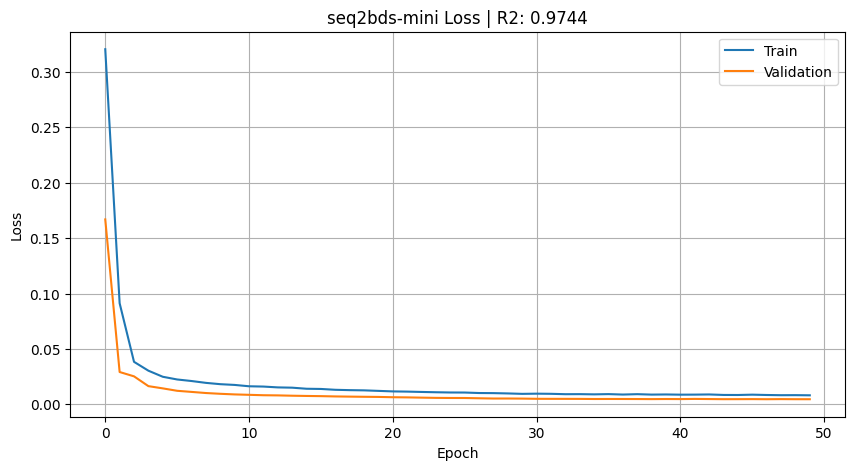

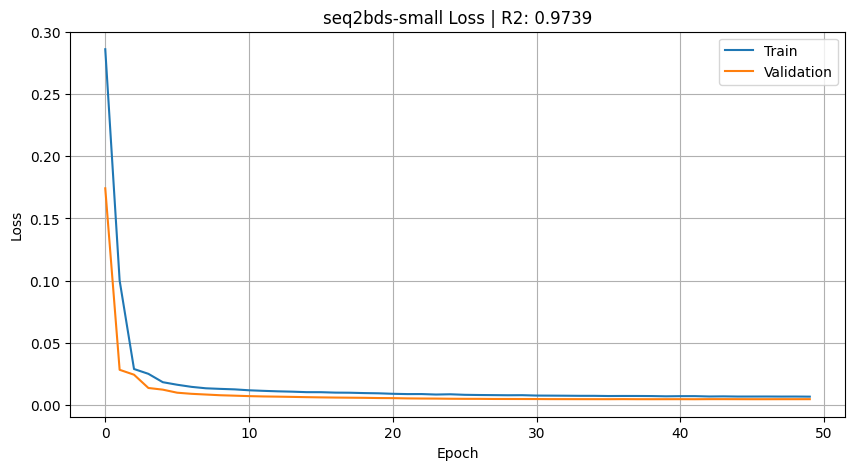

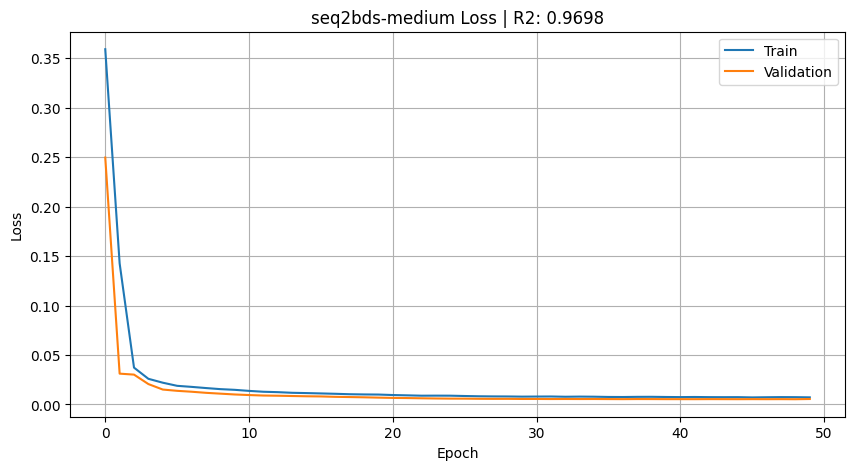

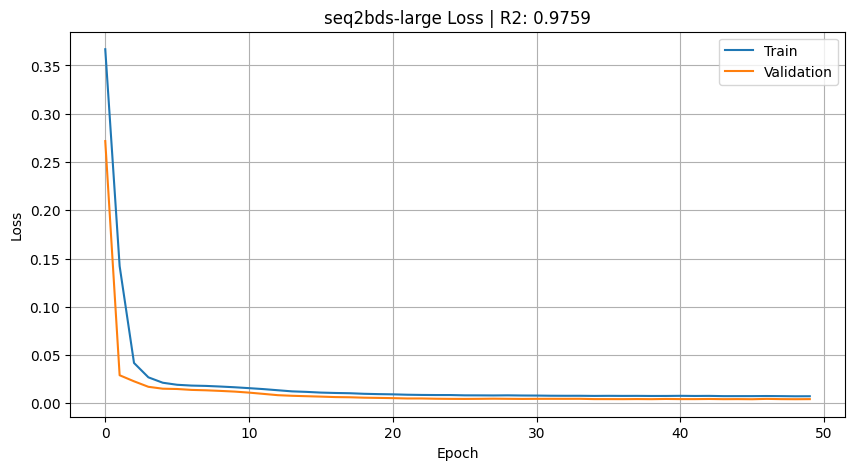

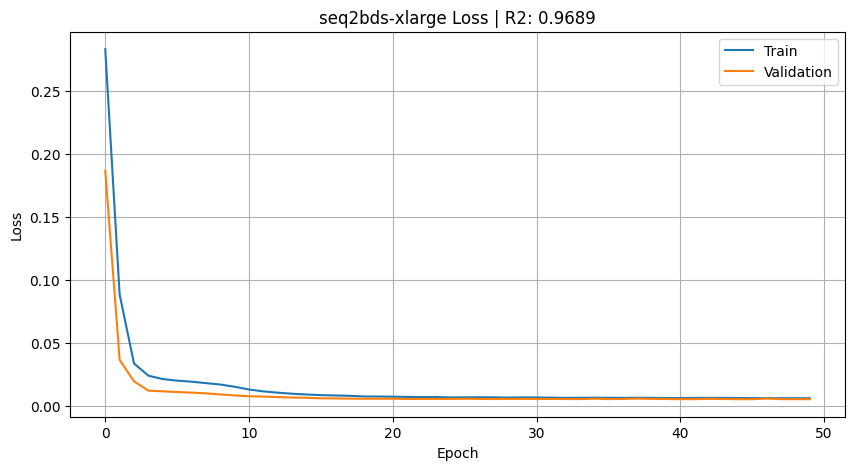

In [12]:
def plot_loss(model):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(model["train_loss"], label="Train")
    ax.plot(model["val_loss"], label="Validation")

    ax.set_title(f"{model['name']} Loss | R2: {model['r2']:.4f}")

    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)

    plt.close(fig)
    return fig


if "MODELS" in globals() and MODELS:
    for model in MODELS:
        fig = plot_loss(model)
        display(fig)

        if os.path.exists(f"./models/{model['name']}"):
            fig.savefig(f"./models/{model['name']}/loss.png", dpi=300, bbox_inches="tight")

for save_path in os.listdir("./models"):

    if not os.path.isdir(f"./models/{save_path}"):
        continue

    with open(f"./models/{save_path}/metadata.json", "r") as f:
        model = json.load(f)

    cached = False
    if "MODELS" in globals() and MODELS:
        for cached_model in MODELS:
            if cached_model["name"] == model["name"]:
                cached = True
                break

    if cached:
        continue

    fig = plot_loss(model)
    display(fig)

    fig.savefig(f"./models/{save_path}/loss.png", dpi=300, bbox_inches="tight")